<a href="https://colab.research.google.com/github/jacquelinevanarkel/CulturalEvolutionCollateralSignals-2021/blob/main/Model_Winter_%26_Wedel_(2016).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replication of Winter & Wedel (2016) / Wedel (2012)

Because we decided to first replicate the study, everything about the collateral signals is left out (but taken into account for the ease of implementation later on). After the resutls are replicated, we adjust the model to introduce a division between word categories: communicative words and metacommunicative words.   

## General features

- An **agent** consists of a lexicon of $|W|$ word categories (let's start with 4). ~~One word in that set should be singled out as the *continuer* word. In other words, the entire set of word categories $W$ can be further split up into a set of regular "communicative" words $C$ and a set of "metacommunicative" words $M$, where $W = C \cup M$ and $C \cap M = \varnothing$. Let's start with $|M| = 1$. For the word(s) in the set $M$, additional and/or adapted pressures will apply.~~
    - A **word** is represented by a set of exemplars. 
        - An **exemplar** is represented by a vector that designates a point in an *n*-dimensional space. Let's start with 2 dimensions, and let's have them both range arbitrarily from 0 to 100 (with integer values in between). An example of an exemplar would then be $[15, 25]$ (these individual values in the vector, like 15 and 25, are referred to as "segments" by Wedel, 2012).


- **Initialisation of an agent:** <span class="mark">Just a randomly generated seed set of exemplars for each word category?</span>

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
class Agent():

  def __init__(self, n_words, n_dimensions, n_exemplars = 100, n_continuers=0, similarity_bias_word=True, similarity_bias_segment=True, noise=True, anti_ambiguity_bias=True):
    
    self.n_words = n_words
    self.n_dimensions = n_dimensions
    self.n_exemplars = n_exemplars
    self.n_continuers = n_continuers
    self.similarity_bias_word = similarity_bias_word
    self.similarity_bias_segment = similarity_bias_segment
    self.noise = noise
    self.anti_ambiguity_bias = anti_ambiguity_bias

    # Generate a lexicon as part of the initialisation
    self.lexicon, self.com_words, self.meta_com_words = self.generate_lexicon()

  # Initialising lexicon
  def generate_lexicon(self):

    # Create a lexicon consisting of n_words words each in turn consisting of n_exemplars exemplars
    lexicon = []
    for w in range(self.n_words):
      word = []

      # Define the mean and the covariance to sample from a multivariate normal distribution to create clustered exemplars for the words
      mean = [random.randrange(10, 91) for i in range(self.n_dimensions)]
      cov = [[10, 0], [0, 10]]
      x, y = np.random.multivariate_normal(mean, cov, self.n_exemplars).T
      word.append(list(map(lambda x, y: [x, y], x, y)))
      
      # Plot every word
      plt.scatter(x, y)

      # Initialiase all words as 'communicative words' ('C')
      lexicon.append([word[0], "C"])

    # print(lexicon)

    # Some plot settings
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.show()

    # Split the lexicon into meta communicative words (continuers) and communicative words
    if self.n_continuers:
      if self.n_continuers > self.n_words:
        raise ValueError("The number of continuers must be lower than the number of words.")

      # The continuers are randomly chosen out of the lexicon
      indices_meta = random.sample(range(self.n_words), k=self.n_continuers)
      meta_com_words = []
      for index in indices_meta:
        lexicon[index][1] = "M"
        # Create a separate lexicon with the meta communicative words
        meta_com_words.append(lexicon[index])

      # The words that are not meta communicative words are communicative words
      com_words = [word for word in lexicon if word not in meta_com_words]

      # print("The word categories are split into communicative and metacommunicative words")
      # print("New lexicon:", lexicon)

      # print("Meta:", meta_com_words)
      # print("Com:", com_words)

    # If there are no continuers, the meta communicative words list is empty and all the words in the lexicon are communicative words
    else:
      com_words = lexicon
      meta_com_words = []

    return lexicon, com_words, meta_com_words

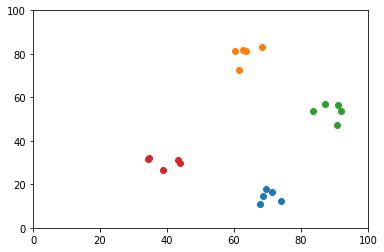

In [ ]:
# Test the initialisation
agent_test = Agent(4, 2)

## Production:

Production begins by selecting one exemplar from a word category: An exemplar is chosen from the target word category with probability proportional to the exemplar's activation level. 
- **Activation level:** 
    - _"Each new exemplar is associated with an initial activation value that decreases over time (i.e., memory decay; Hintzman, 1986; Nosofsky, 1986; Pierrehumbert, 2001)."_ (Winter & Wedel, 2016)
    - _"Activation is calculated as an exponential function of recency, where exemplars that were stored 100 rounds previously have an activation level that is approximately .1% that of a new exemplar)."_ (Wedel, 2012)
    - _"In the model runs shown here, the activation of a exemplar is modeled as $e^{0.2j}$, where $j$ is its list position; this results in a exemplar at position 100 having an activation that is approximately .01 times that of an exemplar at position 1."_ (Wedel, 2012; Appendix)
    - _"The probability of an exemplar being chosen as a production target is its activation relative to the total activation of all exemplars in the category."_ (Wedel, 2012; Appendix)
    - _"Exemplars at list positions greater than 100 are discarded after every round to keep computation efficient; preserving more exemplars slows the rate of change in the system but otherwise does not qualitatively change system behavior."_ (Wedel, 2012; Appendix)
  
Before this target is passed to the listener however, two biases are applied to it:"
- **Similarity biases:** Consists of the following two components:
    - **Within-word category similarity bias:** _"The segment exemplar values of this initial word target are stochastically biased toward the value at the same positions in all the word exemplars within the category"_
        - _"At the word level, population vectors are calculated for the segment values in the target word relative to all segment values at the same position over all exemplars within that word category"_ (Wedel, 2012; Appendix)
    - **Within-segment-dimension similarity bias:** _"each individual segment exemplar value in the target is also stochastically biased toward all other segment exemplars that reference the same dimension across the entire lexicon"_ 
        - _"At the segment level, population vectors are calculated for the segment values in the target word relative to all segment values on that dimension across the lexicon."_ (Wedel, 2012; Appendix)
    - _"To model the influence of both word and segment recency and similarity on production variation, the population vectors at each segment dimension at each level are combined to create a new output that combines information from both within-word category, and within-lexicon sources. The relative contribution of word versus segment population vectors to the output was fixed at .9."_ (Wedel, 2012; Appendix) Marieke: <span class="mark"> --> Wait, what does that last bit mean exactly? That the segment-level population vector contributes 9/10th of what the word-level population vector contributes? Or the other way around? Or something else entirely? Not sure how to interpret this... The Wedel (2012) Appendix refers to the following two articles in this context: (Guenther and Gjaja 1996; Oudeyer 2002); maybe those references could help us? (Also quite likely they won't though.) </span> 
Jacqueline: I think the first option indeed, that the segment-level population contributes 9/10th of what the world-level population contributes, this also makes sense I guess, as the segments within a word should influence each other more, than over the entire lexicon (you produce the different sounds of a word closer to each other than the different sounds of all the words combined of your lexicon right?)
    - _"The population vector with respect to a particular point within a particular segment dimension is a weighted average of all segment exemplars mapped to the category, where both the Euclidean distance from the target exemplar and activation influence each exemplar’s contribution. This is conceptually the same as Nosofsky’s Generalized Context model (Nosofsky 1988), modified to take exemplar activation into account. The formula used to incorporate these factors is given below, where $p$ is the output population vector, y is each position within the segment dimension value of the target under production, $w_y$ is the activation of the exemplar, $x$ is the reference point chosen as the basis for production, and $k$ is a scaling factor influencing the fall off of the contribution to the population vector of the point $y$ relative to $x$:"_ (Wedel, 2012; Appendix)

$$ p = \frac{\sum_y yw_{y} e^{-k |x-y|}}{\sum_{y} w_{y} e^{-k |x-y|}} $$

- _"The value of $k$ used in the simulations shown here is 0.2; a larger value of $k$ reduces the effect of more distant values on the population vector."_ (Wedel, 2012; Appendix). --> Let us start with $k = 0.2$ as well, but make $k$ into a parameter that we can change just in case.


- **Random noise:** _"Noise is added to values of the output target by adding a normally distributed random value. This random value is biased slightly toward the center of the dimension, (i.e. a scale value of 50), in a simple model of production-based lenition (Pierrehumbert 2001; see also e.g. Lindblom et al. 1984 for arguments that the packing of phoneme inventories is in part a consequence of effort-minimization processes). The results described below do not depend on this lenition bias, but they contribute to the illustration by imposing a tendency for each segment exemplar distribution to drift toward the center of each dimension which encourages category merger (see discussion below)."_ 
    - _"Finally, a Gaussian random variable with a standard deviation of 3 is added to the output to introduce noise. This variable is biased slightly toward the center of the dimensional space, creating a fixed attractor at the center of each segment dimension in the system. The bias is calculated using a parabolic response curve given below, where $b$ is the bias added to the output population vector, $p$ is the output population vector, $N$ is the number of points in the space and $G$ is a constant; $b$ is subtracted from outputs greater than $N/2$ (here, 50) and added to those below it."_ (Wedel, 2012; Appendix)
    
$$ b = \frac{(p-N/2)^2}{G}$$

- _"The value of G used in these simulations was 5000, giving a bias toward the center of 0.5 at the edges of the continuum. All else being equal, this bias shifts the distributions of both categories toward the center of the dimension over time, i.e. toward 50, which corresponds to a simple model of articulatory undershoot (cf. Lindblom 1983; Pierrehumbert 2001)."_ (Wedel, 2012; Appendix)

In [4]:
class Production(Agent):

  # def __init__(self, n_words, n_dimensions, n_exemplars = 5, n_continuers=0, similarity_bias_word=True, similarity_bias_segment=True, noise=True, anti_ambiguity_bias=True):
  #       super().__init__(similarity_bias_word, similarity_bias_segment, noise, lexicon)

  
  def select_exemplar(self):

    targets = []
    self.total_activations = []
    for word_index in range(self.n_words):

      # Only store exemplars until position 100
      self.exemplars = self.lexicon[word_index][0][:101]

      print("Exemplars beginning: ", self.exemplars)
      self.activation_exemplars = []
      j = 1
      for exemplar in self.exemplars: 
        # activation = math.exp(0.2*j)
        activation = 1/(0.2*j)
        self.activation_exemplars.append(activation)
        j += 1

      self.total_activations.append(self.activation_exemplars)
      print("Activation exemplars: ", self.activation_exemplars)
      activation_word = sum(self.activation_exemplars)
      print("Activation word: ", activation_word)

      exemplar_probs = [activation/activation_word for activation in self.activation_exemplars]
      print("Exemplars probability: ", exemplar_probs)
      # max_prob = max(exemplar_probs)
      # print("Max probability: ", max_prob)
      target = random.choices(self.exemplars, weights = exemplar_probs, k = 1)
      print("Chose exemplar: ", target)

      targets.append(target[0])
      print(targets)

    return self.add_biases(targets)

  def add_biases(self, targets, k=0.2):
    
    target_exemplars = []
    for target in targets:

      if self.similarity_bias_word:
        word_bias = self.similarity_word(target, k)

      if self.similarity_bias_segment:
        segment_bias = self.similarity_segment(target, k)

        if self.similarity_bias_word:
          total_bias = [(9*a) + b for a, b in zip(word_bias, segment_bias)]
          target_exemplar = [bias / 10 for bias in total_bias]

          if self.noise:
            print("Before Noise:", target_exemplar)
            exemplar = self.added_noise(target_exemplar)
        
        elif self.noise:
          exemplar = self.added_noise(target)

        target_exemplars.append(exemplar)

    print("FINAL:", target_exemplars)
    print("BEFORE BIASES:", targets)

    return target_exemplars

  def similarity_word(self, target, k):

    final = []
    for dimension in range(self.n_dimensions):
      index = 0
      sum = 0
      sum2 = 0
      for exemplar in self.exemplars:
        sum += exemplar[dimension] * self.activation_exemplars[index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
        sum2 += self.activation_exemplars[index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
        index += 1
      final.append(sum/sum2)

    return final

  def similarity_segment(self, target, k):

    final = []
    for dimension in range(self.n_dimensions):
      word_index = 0
      sum = 0
      sum2 = 0
      for word in self.lexicon:
        index = 0
        print("word_index:", word_index)
        for exemplar in word[0]:
          print("Ex dimension: ", exemplar[dimension])
          print("activations: ", self.total_activations[word_index][index])
          print("Math: ", math.exp(-k * abs(target[dimension]-exemplar[dimension])))
          sum += exemplar[dimension] * self.total_activations[word_index][index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
          print("sum: ", sum)
          sum2 += self.total_activations[word_index][index] * math.exp(-k * abs(target[dimension]-exemplar[dimension]))
          index += 1
        word_index += 1
      final.append(sum/sum2)

    return final

  def added_noise(self, target_biases, G = 5000):

    target_noise = []
    for segment in target_biases:
      N = 100
      bias = ((segment - (N/2))**2)/G

      if segment > N/2:
        new_target = segment - bias
      else:
        new_target = segment + bias

      added_noise = np.random.normal(segment, 3, 1)
      target_noise.append(bias + added_noise)

      #target_noise.append(new_target)

    return target_noise

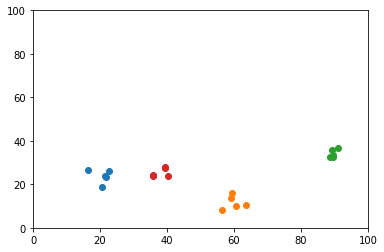

Exemplars beginning:  [[21.644129087103153, 23.424250383480523], [20.682304597222515, 18.59602112198236], [21.504071049965532, 23.832289683279985], [22.605489592319156, 26.287180834522964], [16.457500713636154, 26.744303925171643]]
Activation exemplars:  [5.0, 2.5, 1.6666666666666665, 1.25, 1.0]
Activation word:  11.416666666666666
Exemplars probability:  [0.43795620437956206, 0.21897810218978103, 0.145985401459854, 0.10948905109489052, 0.08759124087591241]
Chose exemplar:  [[21.644129087103153, 23.424250383480523]]
[[21.644129087103153, 23.424250383480523]]
Exemplars beginning:  [[56.46379820299609, 8.100757618344813], [63.626926218495925, 10.296410238730422], [59.1143996845294, 13.93435581338081], [59.27213657603203, 16.212086332622103], [60.47973745093733, 9.962497960778776]]
Activation exemplars:  [5.0, 2.5, 1.6666666666666665, 1.25, 1.0]
Activation word:  11.416666666666666
Exemplars probability:  [0.43795620437956206, 0.21897810218978103, 0.145985401459854, 0.10948905109489052, 0

In [ ]:
test = Production(4, 2).select_exemplar()

##Perception:
        
_"begins the categorization process by calculating the similarity of the speaker output to each category’s stored word exemplars given their activations, in a variant of the Generalized Context Model (Nosofsky 1988). The overall similarities of the speaker output to each category are interpreted as a relative goodness of fit, and the speaker output is then stored as a new exemplar in the best fitting category."_

- **Anti-ambiguity bias:** From Winter & Wedel (2016): _"A final feature of the model is a bias against confusability of word perception, that is, an anti-ambiguity bias. The bias is implemented as follows: the probability of successful identification of an output with a word category is proportional to the degree to which the output uniquely maps to that category and to no other. In this way, distinctive speaker outputs are more likely to be stored than ambiguous outputs, with the result that distinctive phonetic values contribute more to the continuing evolution of the lexicon, both at the word and sound levels."_

In [109]:
class Perception(Agent):

  def similarity(self, signal, k=0.2):

    # Calculate the activations first
    targets = []
    total_activations = []
    for word_index in range(self.n_words):

      # Only store exemplars until position 100
      self.exemplars = self.lexicon[word_index][0][:101]

      print("Exemplars beginning: ", self.exemplars)
      activation_exemplars = []
      j = 1
      for exemplar in self.exemplars: 
        # activation = math.exp(0.2*j)
        activation = 1/(0.2*j)
        activation_exemplars.append(activation)
        j += 1

      total_activations.append(activation_exemplars)

    similarities = []
    word_index = 0
    for word_index in range(self.n_words):
      exemplar_sim = []
      for dimension in range(self.n_dimensions):
        index = 0
        sum = 0
        sum2 = 0
        for exemplar in self.lexicon[word_index][0]:
          sum += exemplar[dimension] * total_activations[word_index][index] * math.exp(-k * abs(signal[dimension]-exemplar[dimension]))
          sum2 += total_activations[word_index][index] * math.exp(-k * abs(signal[dimension]-exemplar[dimension]))
          index += 1
        exemplar_sim.append(sum)

      word_index += 1

      similarities.append(exemplar_sim)
      total_similarities = []
      for word_cat in similarities:
        sum = np.sum(word_cat)
        total_similarities.append(sum)
    print(similarities)
    print(total_similarities)

    max_similarity = max(total_similarities)
    index_max_sim = total_similarities.index(max_similarity)
    print("Signal most similar to word category: ", index_max_sim)

    return self.add_anti_ambiguity_bias(index_max_sim, total_similarities, signal)

  def add_anti_ambiguity_bias(self, index_max_sim, total_similarities, signal):

    print(1/total_similarities[index_max_sim])
    print(sum(total_similarities))
    probability_storage = (total_similarities[index_max_sim])/sum(total_similarities)
    print(probability_storage)

    store = random.choices([True, False], weights = [probability_storage, 1-probability_storage], k = 1)
    
    if store[0]:
      self.lexicon[index_max_sim][0].insert(0, signal)  

    print(self.lexicon[index_max_sim])

    return self.lexicon

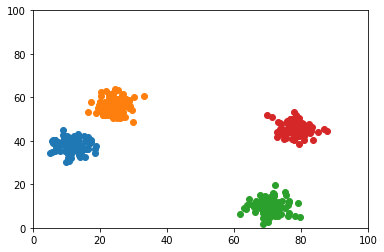

Exemplars beginning:  [[9.75237658137242, 38.92905472886878], [16.266960948116612, 36.29869537030983], [18.471028284663927, 36.13215367783834], [9.948641000137656, 39.33042335349411], [9.319344398916082, 39.69840098485313], [8.987304140352737, 45.18876432309006], [12.457853352485284, 40.91155683984935], [9.33164817785287, 37.871048294335374], [13.33949733331133, 36.14058122042114], [5.736323210303294, 40.099509005458444], [12.754602667313009, 38.33505382610209], [13.95688639584677, 32.670418177933], [6.439071786931641, 40.5016319842337], [10.34988644221063, 41.67974427736982], [16.29672326199114, 41.74281792767967], [6.433395527751543, 40.37422444889608], [11.36299254061532, 33.77259613357665], [10.011821093331505, 39.299944614257356], [9.304115472617255, 40.17363650576549], [11.72163898209669, 37.1898512063813], [11.384021350707826, 31.90286961490613], [8.792146776392803, 39.79738954194651], [11.285540064988792, 41.25787814897235], [7.49536755814402, 39.44776228925373], [10.6928782568

In [115]:
test = Perception(4, 2).similarity([30, 40])